# QC of cellranger-arc mapping using Muon E-MTAB12919_E-MTAB12916

According to the [single cell best practices tutorial](https://www.sc-best-practices.org/chromatin_accessibility/quality_control.html)

    Developed by: Christian Eger 
    Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg
    Created on: 240625
    Last modified: 240625
    environment: multiome_QC-env

## Environment Prep

### import modules

In [1]:
import muon as mu
import os
import scanpy as sc
import seaborn as sns
import numpy as np
from scipy.stats import median_abs_deviation
from muon import atac as ac
import matplotlib.pyplot as plt



sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

/home/ceger/miniforge3/envs/multiome_QC-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### set default paths

In [2]:
data_path = os.path.join(os.getcwd(), '.data')
input_path = os.path.join(data_path, 'input')
output_path = os.path.join(data_path, 'output')

os.listdir(input_path)

['E-MTAB12916_E-MTAB12919.h5mu']

### helper functions

In [3]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

## Read h5mu into mdata object

In [4]:
mdata_input_path = os.path.join(input_path, 'E-MTAB12916_E-MTAB12919.h5mu')
mdata = mu.read_h5mu(mdata_input_path)
mdata

/home/ceger/miniforge3/envs/multiome_QC-env/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/ceger/miniforge3/envs/multiome_QC-env/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 298902 × 3775615
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	298902 x 70711
      obs:	'sample'
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	298902 x 3704904
      obs:	'sample'
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

## QC

### rna

In [5]:
rna = mdata.mod['rna']
rna

AnnData object with n_obs × n_vars = 298902 × 70711
    obs: 'sample'
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

#### Filtering low quality cells

In [7]:
# mitochondrial genes
rna.var["mt"] = rna.var_names.str.startswith("MT-")
# ribosomal genes
rna.var["ribo"] = rna.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
rna.var["hb"] = rna.var_names.str.contains(("^HB[^(P)]"))

In [8]:
sc.pp.calculate_qc_metrics(
    rna, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
rna

AnnData object with n_obs × n_vars = 298902 × 70711
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

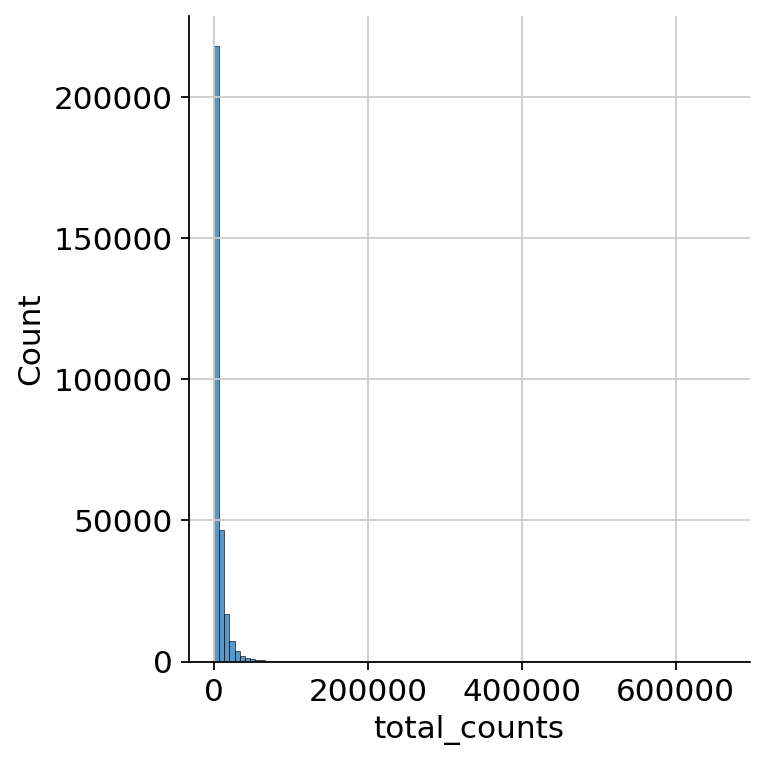

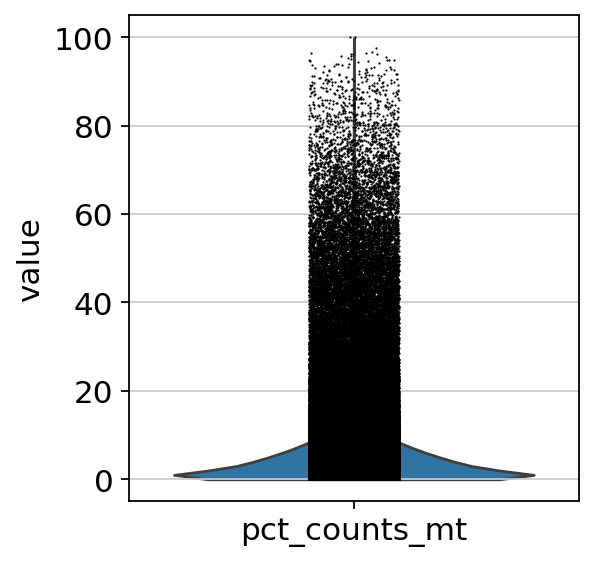

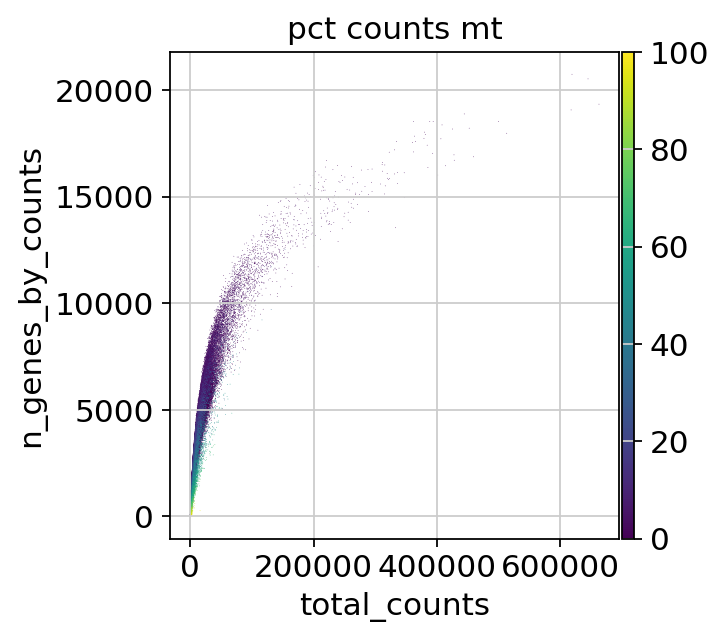

In [9]:
p1 = sns.displot(rna.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(rna, 'total_counts')
p2 = sc.pl.violin(rna, "pct_counts_mt")
p3 = sc.pl.scatter(rna, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [10]:
rna.obs["outlier"] = (
    is_outlier(rna, "log1p_total_counts", 5)
    | is_outlier(rna, "log1p_n_genes_by_counts", 5)
    | is_outlier(rna, "pct_counts_in_top_20_genes", 5)
)
rna.obs.outlier.value_counts()

outlier
False    275549
True      23353
Name: count, dtype: int64

In [11]:
rna.obs["mt_outlier"] = is_outlier(rna, "pct_counts_mt", 3) | (
    rna.obs["pct_counts_mt"] > 8
)
rna.obs.mt_outlier.value_counts()

mt_outlier
False    221143
True      77759
Name: count, dtype: int64

In [12]:
print(f"Total number of cells: {rna.n_obs}")
rna = rna[(~rna.obs.outlier) & (~rna.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {rna.n_obs}")

Total number of cells: 298902
Number of cells after filtering of low quality cells: 213373


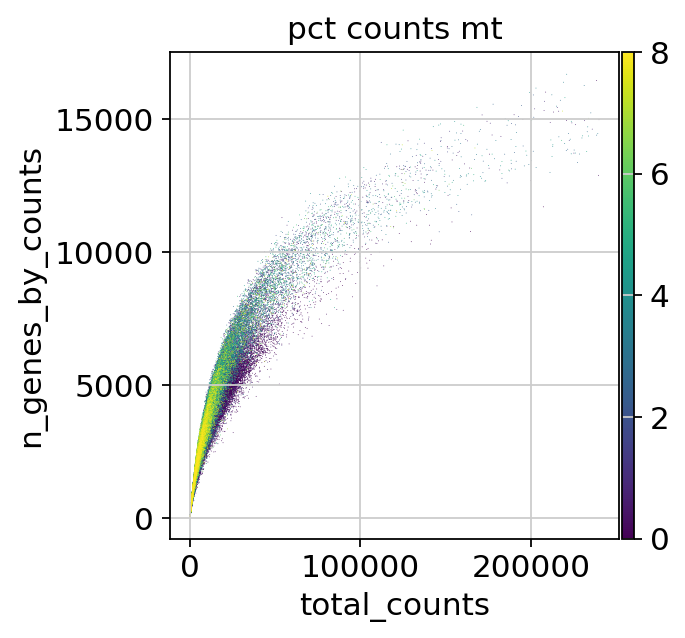

In [13]:
p1 = sc.pl.scatter(rna, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

#### Correction of ambient RNA

skipped for now due to rpy2 issues

#### Doublet detection

In [14]:
rna.obs['sample']

AAACATGCAGCAGGTA-1            HCAHeart9508627_HCAHeart9508819
AAACATGCATAGCTGC-1            HCAHeart9508627_HCAHeart9508819
AAACCAACAAGGTGCA-1            HCAHeart9508627_HCAHeart9508819
AAACCAACACTTAACG-1            HCAHeart9508627_HCAHeart9508819
AAACCAACAGCCGCTA-1            HCAHeart9508627_HCAHeart9508819
                                        ...                  
TTTGTGTTCTACTAAG-1      HCAHeartST13189997_HCAHeartST13188802
TTTGTTGGTAAATTGC-1-1    HCAHeartST13189997_HCAHeartST13188802
TTTGTTGGTAGCAGCT-1      HCAHeartST13189997_HCAHeartST13188802
TTTGTTGGTCATTAGG-1      HCAHeartST13189997_HCAHeartST13188802
TTTGTTGGTTTGAGCA-1      HCAHeartST13189997_HCAHeartST13188802
Name: sample, Length: 213373, dtype: category
Categories (46, object): ['HCAHeart9508627_HCAHeart9508819', 'HCAHeart9508628_HCAHeart9508820', 'HCAHeart9508629_HCAHeart9508821', 'HCAHeart9845431_HCAHeart9917173', ..., 'HCAHeartST13180619_HCAHeartST13177116', 'HCAHeartST13189995_HCAHeartST13188800', 'HCAHeartST13189996

In [15]:
sc.pp.scrublet(rna, batch_key='sample')

<Axes: ylabel='Frequency'>

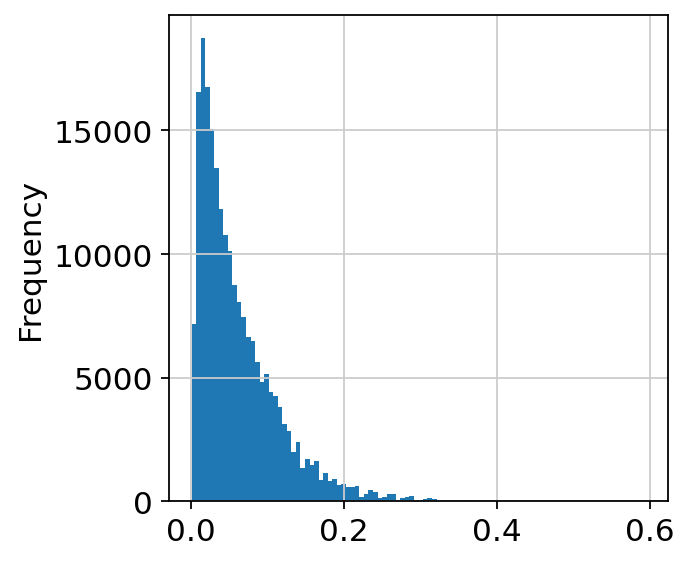

In [16]:
rna.obs['doublet_score'].plot(kind='hist', bins=100)

In [17]:
rna.obs['predicted_doublet'].value_counts()

predicted_doublet
False    203950
True       9423
Name: count, dtype: int64

### atac

In [18]:
atac = mdata.mod['atac']
atac

AnnData object with n_obs × n_vars = 298902 × 3704904
    obs: 'sample'
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'atac', 'files'

#### doublet detection
skipped for now due to rpy2 issue

#### Calculating QC metrics

In [19]:
# Calculate general qc metrics using scanpy
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

# Rename columns
atac.obs.rename(
    columns={
        "n_genes_by_counts": "n_features_per_cell",
        "total_counts": "total_fragment_counts",
    },
    inplace=True,
)

# log-transform total counts and add as column
atac.obs["log_total_fragment_counts"] = np.log10(atac.obs["total_fragment_counts"])

In [20]:
atac.uns['files']

{'fragments': array(['../../../../backup/.data/mapping_py/HCAHeart9508627_HCAHeart9508819/HCAHeart9508627_HCAHeart9508819/outs/atac_fragments.tsv.gz',
        '../../../../backup/.data/mapping_py/HCAHeart9508628_HCAHeart9508820/HCAHeart9508628_HCAHeart9508820/outs/atac_fragments.tsv.gz',
        '../../../../backup/.data/mapping_py/HCAHeart9508629_HCAHeart9508821/HCAHeart9508629_HCAHeart9508821/outs/atac_fragments.tsv.gz',
        '../../../../backup/.data/mapping_py/HCAHeart9845431_HCAHeart9917173/HCAHeart9845431_HCAHeart9917173/outs/atac_fragments.tsv.gz',
        '../../../../backup/.data/mapping_py/HCAHeart9845432_HCAHeart9917174/HCAHeart9845432_HCAHeart9917174/outs/atac_fragments.tsv.gz',
        '../../../../backup/.data/mapping_py/HCAHeart9845433_HCAHeart9917175/HCAHeart9845433_HCAHeart9917175/outs/atac_fragments.tsv.gz',
        '../../../../backup/.data/mapping_py/HCAHeart9845434_HCAHeart9917176/HCAHeart9845434_HCAHeart9917176/outs/atac_fragments.tsv.gz',
        '../../../../

In [21]:
# Calculate the nucleosome signal across cells
# set n=10e3*atac.n_obs for rough estimate but faster run time
ac.tl.nucleosome_signal(atac, n=10e3 * atac.n_obs)

TypeError: expected str, bytes or os.PathLike object, not ndarray

## Combine rna and atac modalities

In [22]:
obs_names = np.intersect1d(rna.obs_names, atac.obs_names)
obs_names

array(['AAACAGCCAAACCTAT-1', 'AAACAGCCAAACTGTT-1', 'AAACAGCCAAAGCTCC-1',
       ..., 'TTTGTTGGTTTGAGCA-1', 'TTTGTTGGTTTGAGGC-1',
       'TTTGTTGGTTTGGCGG-1'], dtype=object)

In [23]:
rna = rna[rna.obs_names.isin(obs_names)]
rna

View of AnnData object with n_obs × n_vars = 213373 × 70711
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet'

In [24]:
atac = atac[atac.obs_names.isin(obs_names)]
atac

View of AnnData object with n_obs × n_vars = 213373 × 3704904
    obs: 'sample', 'n_features_per_cell', 'total_fragment_counts', 'log_total_fragment_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'

In [25]:
mdata = mu.MuData(
    {
        'rna': rna,
        'atac': atac,
    }
)
mdata

MuData object with n_obs × n_vars = 213373 × 3775615
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
  2 modalities
    rna:	213373 x 70711
      obs:	'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      uns:	'scrublet'
    atac:	213373 x 3704904
      obs:	'sample', 'n_features_per_cell', 'total_fragment_counts', 'log_total_fragment_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'atac', 'files'

## Save mdata as h5mu

In [26]:
mdata_output_path = os.path.join(output_path, 'E-MTAB12916_E-MTAB12919-QC.h5mu')
mdata.write_h5mu(mdata_output_path)

os.listdir(output_path)

/home/ceger/miniforge3/envs/multiome_QC-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/home/ceger/miniforge3/envs/multiome_QC-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/home/ceger/miniforge3/envs/multiome_QC-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing

['E-MTAB12916_E-MTAB12919-QC-Norm.h5mu', 'E-MTAB12916_E-MTAB12919-QC.h5mu']